In [1]:
import sys
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt

# Sklearn metrics
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

# IPython utilities
from IPython.display import clear_output
from tqdm import tqdm

# HuggingFace transformers
from transformers import ViTForImageClassification, get_scheduler
from torch.optim import AdamW

# PyTorch AMP (Mixed Precision)
from torch.cuda.amp import GradScaler, autocast

# Project imports
sys.path.insert(0, '../..')  # Add project root to path
sys.path.insert(0, '../../scripts')
from load_data import split_data
from src.rakuten_image.datasets import RakutenImageDataset

print(f"✓ All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

c:\Users\xiaos\anaconda3\envs\rakuten_groupe\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All imports successful
PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
VRAM: 8.59 GB


In [2]:
CONFIG = {
    # Chemins des données
    "data_dir": Path("../../data/raw"),
    "img_dir": Path("../../data/raw/images/image_train"),
    "checkpoint_dir": Path("../../models/image/vit_mit_b0_v1_20251218"),

    # Configuration du modèle
    "model_name": "google/vit-base-patch16-224",
    "img_size": 224,

    # Hyperparamètres d'entraînement
    "batch_size": 32, 
    "num_epochs": 20,
    "learning_rate": 2e-5,
    "weight_decay": 0.05,
    "warmup_ratio": 0.1,

    # Split train/validation (85% train, 15% validation)
    "val_split": 0.15,
    "random_state": 42,

    # Early stopping
    "early_stopping_patience": 3,

    # Configuration hardware
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_workers": 2,
    "use_amp": True,  # Utiliser Automatic Mixed Precision
}

In [3]:
print("\n📂 Loading data...")

# Use unified split function (SAME as text notebooks!)
X_dev, X_holdout, y_dev, y_holdout = split_data()

# Create full dataframes
df_dev = X_dev.copy()
df_dev['prdtypecode'] = y_dev

df_holdout = X_holdout.copy()
df_holdout['prdtypecode'] = y_holdout

print(f"✓ Data loaded: {len(df_dev) + len(df_holdout):,} total samples")
print(f"  Development: {len(df_dev):,} samples (85%)")
print(f"  Hold-out:    {len(df_holdout):,} samples (15%)")
print(f"  Unique classes: {df_dev['prdtypecode'].nunique()}")

# Global Label Encoding (LabelEncoder already imported in first cell)
print("\n📊 Label encoding...")

label_encoder = LabelEncoder()
# Fit on combined data to ensure all classes are seen
all_labels = pd.concat([df_dev['prdtypecode'], df_holdout['prdtypecode']])
label_encoder.fit(all_labels)

df_dev['encoded_label'] = label_encoder.transform(df_dev['prdtypecode'])
df_holdout['encoded_label'] = label_encoder.transform(df_holdout['prdtypecode'])

num_classes = len(label_encoder.classes_)
print(f"✓ Encoding complete")
print(f"  Encoded range: 0 to {num_classes - 1}")
print(f"  Total classes: {num_classes}")
assert num_classes == 27, f"Expected 27 classes, got {num_classes}"


📂 Loading data...
✓ Data loaded: 84,916 total samples
  Development: 72,178 samples (85%)
  Hold-out:    12,738 samples (15%)
  Unique classes: 27

📊 Label encoding...
✓ Encoding complete
  Encoded range: 0 to 26
  Total classes: 27


In [4]:
print("\n🔧 Création des datasets et dataloaders...")

# Transformations pour l'entraînement (avec augmentation)
train_transform = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=2, magnitude=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Transformations pour validation/test (sans augmentation)
val_transform = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Créer les datasets (utilisant encoded_label au lieu de prdtypecode)
train_dataset = RakutenImageDataset(
    dataframe=df_dev,
    image_dir=CONFIG["img_dir"],
    transform=train_transform,
    label_col="encoded_label",  # Utiliser les labels pré-encodés
    verify_images=False
)

val_dataset = RakutenImageDataset(
    dataframe=df_holdout,
    image_dir=CONFIG["img_dir"],
    transform=val_transform,
    label_col="encoded_label",
    verify_images=False
)

test_dataset = RakutenImageDataset(
    dataframe=df_holdout,
    image_dir=CONFIG["img_dir"],
    transform=val_transform,
    label_col="encoded_label",
    verify_images=False
)

print(f"✓ Datasets créés")
print(f"  Training:   {len(train_dataset):,} échantillons")
print(f"  Validation: {len(val_dataset):,} échantillons")
print(f"  Hold-out:   {len(test_dataset):,} échantillons")
print(f"  Classes:    {train_dataset.num_classes}")

# Créer les dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=CONFIG["num_workers"],
    pin_memory=True,
    drop_last=True  # Pour stabilité BatchNorm
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

print(f"\n✓ DataLoaders créés (batch_size={CONFIG['batch_size']})")
print(f"  Train:      {len(train_loader):,} batches")
print(f"  Validation: {len(val_loader):,} batches")
print(f"  Hold-out:   {len(test_loader):,} batches")

# Sanity check
try:
    images, labels = next(iter(train_loader))
    print(f"\n✓ Sanity check: Batch shape {images.shape}, Labels {labels.shape}")
    print(f"✅ All DataLoaders working correctly!")
except Exception as e:
    print(f"❌ Error: {e}")


🔧 Création des datasets et dataloaders...
✓ Labels already zero-indexed: 27 classes
✓ RakutenImageDataset initialized: 72178 samples, 27 classes
✓ Labels already zero-indexed: 27 classes
✓ RakutenImageDataset initialized: 12738 samples, 27 classes
✓ Labels already zero-indexed: 27 classes
✓ RakutenImageDataset initialized: 12738 samples, 27 classes
✓ Datasets créés
  Training:   72,178 échantillons
  Validation: 12,738 échantillons
  Hold-out:   12,738 échantillons
  Classes:    27

✓ DataLoaders créés (batch_size=32)
  Train:      2,255 batches
  Validation: 399 batches
  Hold-out:   399 batches

✓ Sanity check: Batch shape torch.Size([32, 3, 224, 224]), Labels torch.Size([32])
✅ All DataLoaders working correctly!


In [5]:
print("\n🏗️ Initialisation du modèle ViT...")

# Charger le modèle pré-entraîné
model = ViTForImageClassification.from_pretrained(
    CONFIG["model_name"],
    num_labels=num_classes,  # Utiliser num_classes de l'encodage global
    ignore_mismatched_sizes=True,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)
model.to(CONFIG["device"])

print(f"✓ Modèle chargé: {CONFIG['model_name']}")
print(f"  Nombre de classes: {num_classes}")

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"  Paramètres totaux: {total_params:,}")
print(f"  Paramètres entraînables: {trainable_params:,}")


🏗️ Initialisation du modèle ViT...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([27]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([27, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Modèle chargé: google/vit-base-patch16-224
  Nombre de classes: 27
  Paramètres totaux: 85,819,419
  Paramètres entraînables: 85,819,419


In [6]:
print("\n⚙️ Configuration de l'optimiseur et du scheduler...")

# Optimiseur AdamW
optimizer = AdamW(
    model.parameters(),
    lr=CONFIG["learning_rate"],
    weight_decay=CONFIG["weight_decay"]
)

# Scheduler avec warmup linéaire
total_steps = len(train_loader) * CONFIG["num_epochs"]
num_warmup_steps = int(total_steps * CONFIG["warmup_ratio"])

scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)

# Initialiser GradScaler pour AMP
scaler = GradScaler() if CONFIG["use_amp"] else None

print(f"✓ Optimiseur: AdamW")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Weight decay: {CONFIG['weight_decay']}")
print(f"✓ Scheduler: Linear warmup")
print(f"  Warmup steps: {num_warmup_steps:,}/{total_steps:,}")
if CONFIG["use_amp"]:
    print(f"✓ GradScaler initialisé pour AMP")

# Créer le répertoire de checkpoints
CONFIG["checkpoint_dir"].mkdir(parents=True, exist_ok=True)
print(f"✓ Répertoire checkpoints: {CONFIG['checkpoint_dir']}")

# Sauvegarder la configuration
with open(CONFIG["checkpoint_dir"] / "config.json", "w") as f:
    json.dump({k: str(v) for k, v in CONFIG.items()}, f, indent=2)
print(f"✓ Configuration sauvegardée")


⚙️ Configuration de l'optimiseur et du scheduler...
✓ Optimiseur: AdamW
  Learning rate: 2e-05
  Weight decay: 0.05
✓ Scheduler: Linear warmup
  Warmup steps: 4,510/45,100
✓ GradScaler initialisé pour AMP
✓ Répertoire checkpoints: ..\..\checkpoints\vit_production
✓ Configuration sauvegardée


C:\Users\xiaos\AppData\Local\Temp\ipykernel_16608\1428896284.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if CONFIG["use_amp"] else None


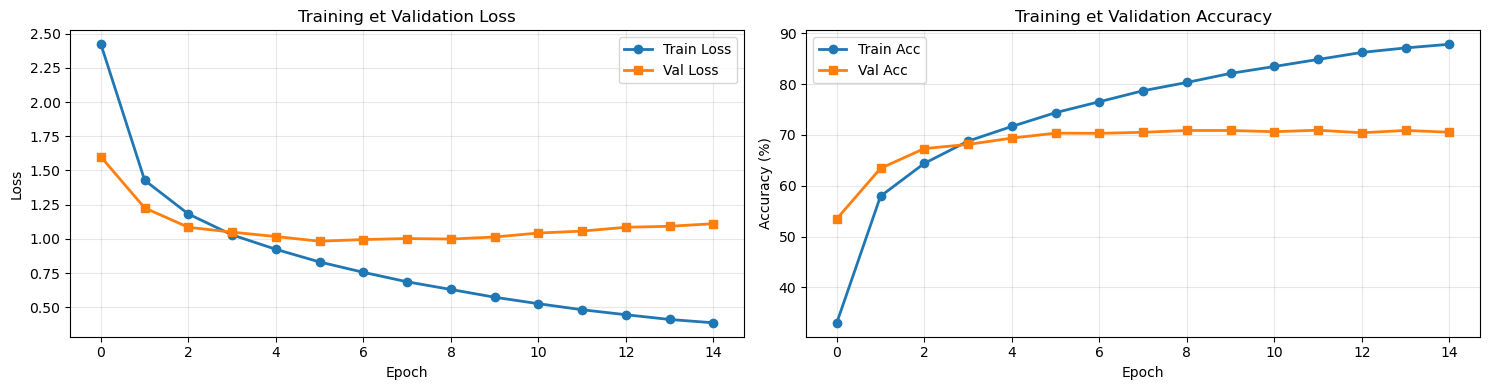


📊 Statistiques actuelles:
  Meilleure Val Acc: 70.93% (Patience: 3/3)
  Meilleure Val Loss: 1.0570

⚠️ Early stopping déclenché après 15 epochs

✅ ENTRAÎNEMENT TERMINÉ


In [7]:
print("\n" + "=" * 80)
print("🚀 DÉMARRAGE DE L'ENTRAÎNEMENT")
print("=" * 80)
print(f"Temps estimé: ~{len(train_loader) * CONFIG['num_epochs'] * 0.8 / 60:.0f} minutes")
print(f"AMP activé: {CONFIG['use_amp']}")
print("=" * 80 + "\n")

# Variables pour le tracking
best_val_acc = 0.0
best_val_loss = float('inf')
patience_counter = 0
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

# Fonction pour mettre à jour les graphiques
def update_plots():
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    
    # Plot Loss
    axes[0].plot(history["train_loss"], label='Train Loss', marker='o', linewidth=2)
    axes[0].plot(history["val_loss"], label='Val Loss', marker='s', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training et Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot Accuracy
    axes[1].plot(history["train_acc"], label='Train Acc', marker='o', linewidth=2)
    axes[1].plot(history["val_acc"], label='Val Acc', marker='s', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training et Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Afficher les statistiques
    print(f"\n📊 Statistiques actuelles:")
    print(f"  Meilleure Val Acc: {best_val_acc:.2f}% (Patience: {patience_counter}/{CONFIG['early_stopping_patience']})")
    print(f"  Meilleure Val Loss: {best_val_loss:.4f}")

# Boucle d'entraînement principale
for epoch in range(CONFIG["num_epochs"]):
    print(f"\nEpoch {epoch + 1}/{CONFIG['num_epochs']}")
    print("=" * 80)
    
    # -------------------- Phase d'entraînement --------------------
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", unit="batch")
    for images, labels in train_pbar:
        images, labels = images.to(CONFIG["device"]), labels.to(CONFIG["device"])
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass avec AMP
        if CONFIG["use_amp"]:
            with autocast():
                outputs = model(pixel_values=images, labels=labels)
                loss = outputs.loss
            
            # Backward pass avec scaler
            scaler.scale(loss).backward()
            
            # Unscale avant gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # Optimizer step avec scaler
            scaler.step(optimizer)
            scaler.update()
        else:
            # Forward pass sans AMP
            outputs = model(pixel_values=images, labels=labels)
            loss = outputs.loss
            
            # Backward pass standard
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        
        scheduler.step()
        
        # Métriques
        train_loss += loss.item()
        predictions = torch.argmax(outputs.logits, dim=-1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
        
        # Mise à jour de la barre de progression
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.0 * train_correct / train_total:.2f}%'
        })
    
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100.0 * train_correct / train_total
    
    # -------------------- Phase de validation --------------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    val_pbar = tqdm(val_loader, desc=f"Validation", unit="batch")
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(CONFIG["device"]), labels.to(CONFIG["device"])
            
            # Forward pass validation (avec AMP si activé)
            if CONFIG["use_amp"]:
                with autocast():
                    outputs = model(pixel_values=images, labels=labels)
                    loss = outputs.loss
            else:
                outputs = model(pixel_values=images, labels=labels)
                loss = outputs.loss
            
            val_loss += loss.item()
            predictions = torch.argmax(outputs.logits, dim=-1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.0 * val_correct / val_total:.2f}%'
            })
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * val_correct / val_total
    
    # -------------------- Mise à jour de l'historique --------------------
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_accuracy)
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_accuracy)
    
    print(f"\n📊 Résultats Epoch {epoch + 1}:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
    print(f"  Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_accuracy:.2f}%")
    
    # -------------------- Sauvegarde du meilleur modèle --------------------
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_val_loss = avg_val_loss
        patience_counter = 0
        
        # Save with descriptive name including epoch and metrics
        model_filename = f"vit_mit_b0_epoch{epoch+1:02d}_f1_{val_f1:.4f}.pth"
        checkpoint_path = CONFIG["checkpoint_dir"] / model_filename
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict() if CONFIG["use_amp"] else None,
            'val_acc': val_accuracy,
            'val_loss': avg_val_loss,
            'train_acc': train_accuracy,
            'train_loss': avg_train_loss,
        }, checkpoint_path)
        
        print(f"  ✅ Meilleur modèle sauvegardé! (Val Acc: {val_accuracy:.2f}%)")
    else:
        patience_counter += 1
        print(f"  ⏳ Pas d'amélioration ({patience_counter}/{CONFIG['early_stopping_patience']})")
    
    # -------------------- Mise à jour des graphiques --------------------
    update_plots()
    
    # -------------------- Early Stopping --------------------
    if patience_counter >= CONFIG["early_stopping_patience"]:
        print(f"\n⚠️ Early stopping déclenché après {epoch + 1} epochs")
        break

print("\n" + "=" * 80)
print("✅ ENTRAÎNEMENT TERMINÉ")
print("=" * 80)

In [8]:
print("\n" + "=" * 80)
print("📊 ÉVALUATION FINALE")
print("=" * 80)

# Charger le meilleur modèle
checkpoint = torch.load(CONFIG["checkpoint_dir"] / "best_model.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"\n✅ Statistiques du meilleur modèle:")
print(f"  Epoch: {checkpoint['epoch']}")
print(f"  Val Accuracy: {checkpoint['val_acc']:.2f}%")
print(f"  Val Loss: {checkpoint.get('val_loss', 'N/A')}")

# Évaluation sur le set de validation
print("\n" + "="*80)
print("Évaluation sur Validation Set")
print("="*80)
all_preds_val = []
all_labels_val = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Validation"):
        images = images.to(CONFIG["device"])
        
        if CONFIG["use_amp"]:
            with autocast():
                outputs = model(pixel_values=images)
        else:
            outputs = model(pixel_values=images)
            
        predictions = torch.argmax(outputs.logits, dim=-1)
        all_preds_val.extend(predictions.cpu().numpy())
        all_labels_val.extend(labels.numpy())

val_acc_final = accuracy_score(all_labels_val, all_preds_val)
val_f1_macro = f1_score(all_labels_val, all_preds_val, average='macro')
val_f1_weighted = f1_score(all_labels_val, all_preds_val, average='weighted')

print(f"\n✓ Validation Accuracy: {val_acc_final*100:.2f}%")
print(f"✓ Validation F1-Score (Macro): {val_f1_macro:.4f}")
print(f"✓ Validation F1-Score (Weighted): {val_f1_weighted:.4f}")

# Évaluation sur le hold-out test set
print("\n" + "="*80)
print("Évaluation sur Hold-out Test Set (Final Benchmark)")
print("="*80)
all_preds_test = []
all_labels_test = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Hold-out Test"):
        images = images.to(CONFIG["device"])
        
        if CONFIG["use_amp"]:
            with autocast():
                outputs = model(pixel_values=images)
        else:
            outputs = model(pixel_values=images)
            
        predictions = torch.argmax(outputs.logits, dim=-1)
        all_preds_test.extend(predictions.cpu().numpy())
        all_labels_test.extend(labels.numpy())

test_acc_final = accuracy_score(all_labels_test, all_preds_test)
test_f1_macro = f1_score(all_labels_test, all_preds_test, average='macro')
test_f1_weighted = f1_score(all_labels_test, all_preds_test, average='weighted')

print(f"\n✓ Hold-out Test Accuracy: {test_acc_final*100:.2f}%")
print(f"✓ Hold-out Test F1-Score (Macro): {test_f1_macro:.4f}")
print(f"✓ Hold-out Test F1-Score (Weighted): {test_f1_weighted:.4f}")

# Rapport de classification détaillé (sur hold-out test)
print("\n📋 Rapport de Classification (Hold-out Test):")
print("=" * 80)
print(classification_report(all_labels_test, all_preds_test, digits=4, zero_division=0))

# Sauvegarder l'historique
history_path = CONFIG["checkpoint_dir"] / "training_history.json"
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)

# Sauvegarder les résultats finaux avec F1 scores
results = {
    "best_epoch": int(checkpoint['epoch']),
    "val_acc": float(checkpoint['val_acc']),
    "final_val_acc": float(val_acc_final * 100),
    "final_val_f1_macro": float(val_f1_macro),
    "final_val_f1_weighted": float(val_f1_weighted),
    "final_test_acc": float(test_acc_final * 100),
    "final_test_f1_macro": float(test_f1_macro),
    "final_test_f1_weighted": float(test_f1_weighted),
    "num_classes": int(num_classes),
    "model": CONFIG["model_name"]
}

results_path = CONFIG["checkpoint_dir"] / "final_results.json"
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Historique sauvegardé: {history_path}")
print(f"✅ Résultats finaux sauvegardés: {results_path}")
print(f"✅ Meilleur modèle: {CONFIG['checkpoint_dir'] / 'best_model.pth'}")
print("\n" + "=" * 80)
print("🎉 ÉVALUATION COMPLÈTE")
print("=" * 80)


📊 ÉVALUATION FINALE

✅ Statistiques du meilleur modèle:
  Epoch: 12
  Val Accuracy: 70.93%
  Val Loss: 1.0570081424593627

Évaluation sur Validation Set


Validation:   0%|          | 0/399 [00:00<?, ?it/s]C:\Users\xiaos\AppData\Local\Temp\ipykernel_16608\1569524233.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 399/399 [00:30<00:00, 12.89it/s]



✓ Validation Accuracy: 70.93%
✓ Validation F1-Score (Macro): 0.6804
✓ Validation F1-Score (Weighted): 0.7070

Évaluation sur Hold-out Test Set (Final Benchmark)


Hold-out Test:   0%|          | 0/399 [00:00<?, ?it/s]C:\Users\xiaos\AppData\Local\Temp\ipykernel_16608\1569524233.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Hold-out Test: 100%|██████████| 399/399 [00:30<00:00, 12.88it/s]


✓ Hold-out Test Accuracy: 70.93%
✓ Hold-out Test F1-Score (Macro): 0.6804
✓ Hold-out Test F1-Score (Weighted): 0.7070

📋 Rapport de Classification (Hold-out Test):
              precision    recall  f1-score   support

           0     0.6843    0.6360    0.6593       467
           1     0.6429    0.6941    0.6675       376
           2     0.5172    0.6548    0.5779       252
           3     0.7099    0.7440    0.7266       125
           4     0.6500    0.7132    0.6801       401
           5     0.9415    0.9494    0.9454       593
           6     0.5769    0.3913    0.4663       115
           7     0.4940    0.4473    0.4695       731
           8     0.5263    0.3215    0.3992       311
           9     0.7518    0.8124    0.7810       757
          10     0.8559    0.7851    0.8190       121
          11     0.5194    0.5374    0.5283       374
          12     0.6040    0.5556    0.5788       486
          13     0.6198    0.6321    0.6259       761
          14     0.8551 

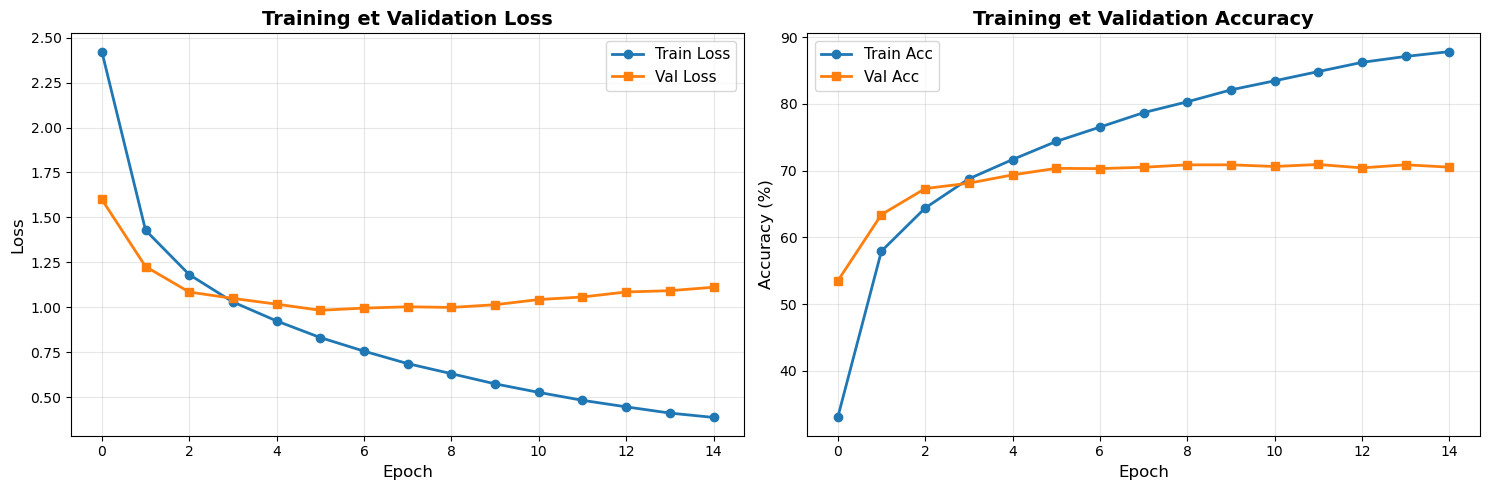

✓ Graphiques sauvegardés: ..\..\checkpoints\vit_production\training_curves.png


In [9]:
# Créer et sauvegarder les graphiques finaux
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axes[0].plot(history["train_loss"], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history["val_loss"], label='Val Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training et Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(history["train_acc"], label='Train Acc', marker='o', linewidth=2)
axes[1].plot(history["val_acc"], label='Val Acc', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training et Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = CONFIG["checkpoint_dir"] / 'training_curves.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Graphiques sauvegardés: {plot_path}")

In [ ]:
print("=" * 80)
print("📊 RÉSUMÉ DE L'ENTRAÎNEMENT")
print("=" * 80)

total_samples = len(df_dev) + len(df_holdout)

print(f"\nDonnées:")
print(f"  Total échantillons: {total_samples:,}")
print(f"  Training: {len(train_dataset):,} (~{len(train_dataset)/total_samples*100:.1f}%)")
print(f"  Validation: {len(val_dataset):,} (~{len(val_dataset)/total_samples*100:.1f}%)")
print(f"  Hold-out: {len(test_dataset):,} (15.0%)")
print(f"  Classes: {num_classes}")

print(f"\nModèle:")
print(f"  Architecture: {CONFIG['model_name']}")
print(f"  Paramètres entraînables: {trainable_params:,}")

print(f"\nEntraînement:")
print(f"  Epochs complétés: {len(history['train_loss'])}")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")

print(f"\nMeilleurs Résultats (sur Validation):")
print(f"  Best epoch: {checkpoint['epoch']}")
print(f"  Best val accuracy: {checkpoint['val_acc']:.2f}%")

print(f"\nRésultats Finaux:")
print(f"  Final val accuracy: {val_acc_final*100:.2f}%")
print(f"  Final hold-out test accuracy: {test_acc_final*100:.2f}%")

print(f"\nFichiers sauvegardés:")
print(f"  Checkpoint: {CONFIG['checkpoint_dir'] / 'MiT_best_model.pth'}")
print(f"  Historique: {CONFIG['checkpoint_dir'] / 'training_history.json'}")
print(f"  Résultats: {CONFIG['checkpoint_dir'] / 'final_results.json'}")
print(f"  Configuration: {CONFIG['checkpoint_dir'] / 'config.json'}")
print(f"  Graphiques: {CONFIG['checkpoint_dir'] / 'training_curves.png'}")

print("\n" + "=" * 80)
print("✅ ENTRAÎNEMENT PRODUCTION ViT TERMINÉ")
print("=" * 80)

📊 RÉSUMÉ DE L'ENTRAÎNEMENT

Données:
  Total échantillons: 84,916
  Training: 72,178 (~85.0%)
  Validation: 12,738 (~15.0%)
  Hold-out: 12,738 (15.0%)
  Classes: 27

Modèle:
  Architecture: google/vit-base-patch16-224
  Paramètres entraînables: 85,819,419

Entraînement:
  Epochs complétés: 15
  Batch size: 32
  Learning rate: 2e-05

Meilleurs Résultats (sur Validation):
  Best epoch: 12
  Best val accuracy: 70.93%

Résultats Finaux:
  Final val accuracy: 70.93%
  Final hold-out test accuracy: 70.93%

Fichiers sauvegardés:
  Checkpoint: ..\..\checkpoints\vit_production\best_model.pth
  Historique: ..\..\checkpoints\vit_production\training_history.json
  Résultats: ..\..\checkpoints\vit_production\final_results.json
  Configuration: ..\..\checkpoints\vit_production\config.json
  Graphiques: ..\..\checkpoints\vit_production\training_curves.png

✅ ENTRAÎNEMENT PRODUCTION ViT TERMINÉ
